Expected Loss (EL) with correlation: 91.5
Unexpected Loss (UL) with correlation: 0.0
Value-at-Risk (VaR) at 95% confidence level with correlation: 91.5


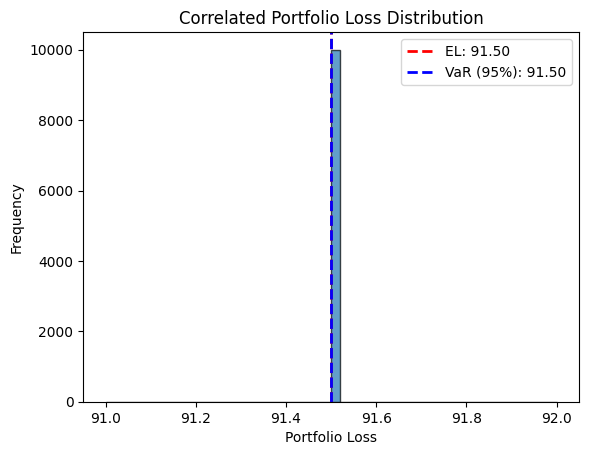

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load the datasets
financial_df = pd.read_csv('financial_metrics.csv')
client_info_df = pd.read_csv('client_info.csv')

# Calculate PD and assume LGD
client_info_df['PD'] = client_info_df['default']
client_info_df['LGD'] = 0.5

# Generate a random correlation matrix
np.random.seed(42)
num_clients = len(client_info_df)
random_matrix = np.random.rand(num_clients, num_clients)
correlation_matrix = (random_matrix + random_matrix.T) / 2  # Make it symmetric
np.fill_diagonal(correlation_matrix, 1)  # Set diagonal to 1
correlation_matrix = np.dot(correlation_matrix, correlation_matrix.T)  # Ensure positive semi-definite

# Number of simulations
num_simulations = 10000

# Generate correlated random variables using Cholesky decomposition
L = np.linalg.cholesky(correlation_matrix)
uncorrelated_randoms = norm.ppf(np.random.uniform(size=(num_simulations, num_clients)))
correlated_randoms = uncorrelated_randoms.dot(L.T)

# Convert correlated randoms to default indicators
pd_values = client_info_df['PD'].values
correlated_defaults = correlated_randoms < norm.ppf(pd_values)
correlated_defaults_df = pd.DataFrame(correlated_defaults)

# Calculate losses for correlated defaults
lgd_values = client_info_df['LGD'].values
correlated_losses = correlated_defaults_df * lgd_values
correlated_portfolio_losses = correlated_losses.sum(axis=1)

# Calculate EL, UL, and VaR
expected_loss_corr = correlated_portfolio_losses.mean()
unexpected_loss_corr = correlated_portfolio_losses.std()
var_95_corr = np.percentile(correlated_portfolio_losses, 95)

print(f"Expected Loss (EL) with correlation: {expected_loss_corr}")
print(f"Unexpected Loss (UL) with correlation: {unexpected_loss_corr}")
print(f"Value-at-Risk (VaR) at 95% confidence level with correlation: {var_95_corr}")

# Plot the distribution of correlated portfolio losses
plt.hist(correlated_portfolio_losses, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(expected_loss_corr, color='r', linestyle='dashed', linewidth=2, label=f'EL: {expected_loss_corr:.2f}')
plt.axvline(var_95_corr, color='b', linestyle='dashed', linewidth=2, label=f'VaR (95%): {var_95_corr:.2f}')
plt.xlabel('Portfolio Loss')
plt.ylabel('Frequency')
plt.title('Correlated Portfolio Loss Distribution')
plt.legend()
plt.show()
